In [98]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels as stats
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import seaborn as sns

In [99]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
data = pd.read_excel("Downloads/Final_RA_data.xlsx")

### Missing Value Imputation
### Creating df_imp by imputing missing values using the following technique-
#### Values for each colum are Linearly interpolating  at Company level
#### Some missing values still remain because linear interpolation does not work when entire column is NaN. So, the remaining missing values are replaced with the Column Mean*. 

#### NOTE- The Column Mean is calculated taking the entire column into account and not at Company level

In [101]:
df = data[['Companies','sgna','current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','gross_profit','Litigation', 'Numbers', 'developed', 'Multinational', 'Australia', 'Belgium', 'Germany', 'India', 'Ireland', 'Norway', 'Singapore', 'Sweden', 'UK', 'USA', 
      'policy_reforms_australia', 'policy_reforms_germany', 'policy_reforms_india', 'policy_reforms_NORWAY', 'policy_reforms_SINGAPORE', 'policy_reforms_SWEDEN','policy_reforms_UK',
      'policy_reforms_usa', 'GDP per capita growth (annual %)', 'Life expectancy at birth, total (years)', 'Mortality rate, infant (per 1,000 live births)', 
      'Population, total', 'Individuals using the Internet (% of population)', 'Physicians (per 1,000 people)','acquisitions']]

df.isnull().sum()

Companies                                              0
sgna                                                1011
current_assets                                       305
age                                                    1
ppe                                                  835
emp                                                 1153
operating_expenses                                   369
liabilities                                          656
book_value                                          1022
gross_profit                                         463
Litigation                                             1
Numbers                                                0
developed                                              0
Multinational                                        569
Australia                                              0
Belgium                                                0
Germany                                                0
India                          

#### Linear Interpolation of  Missing Values

In [102]:
df = df.groupby("Companies").transform(lambda x: x.interpolate(limit_direction='both'))
df.isnull().sum()

sgna                                                 584
current_assets                                        73
age                                                    0
ppe                                                  638
emp                                                  782
operating_expenses                                   207
liabilities                                          570
book_value                                           874
gross_profit                                         297
Litigation                                             0
Numbers                                                0
developed                                              0
Multinational                                        460
Australia                                              0
Belgium                                                0
Germany                                                0
India                                                  0
Ireland                        

#### Replacing remaining missing Values with Column Mean

In [103]:
df['liabilities'] = df['liabilities'].transform(lambda x: x.fillna(x.mean()))
df['current_assets'] = df['current_assets'].transform(lambda x: x.fillna(x.mean()))
df['ppe'] = df['ppe'].transform(lambda x: x.fillna(x.mean()))
df['operating_expenses'] = df['operating_expenses'].transform(lambda x: x.fillna(x.mean()))
df['emp'] = df['emp'].transform(lambda x: x.fillna(x.mean()))
df['book_value'] = df['book_value'].transform(lambda x: x.fillna(x.mean()))
df['gross_profit'] = df['gross_profit'].transform(lambda x: x.fillna(x.mean()))
df['sgna'] = df['sgna'].transform(lambda x: x.fillna(x.mean()))
df['Multinational'] = df['Multinational'].transform(lambda x: x.fillna(x.mean()))
df['GDP per capita growth (annual %)'] = df['GDP per capita growth (annual %)'].transform(lambda x: x.fillna(x.mean()))
df['Life expectancy at birth, total (years)'] = df['Life expectancy at birth, total (years)'].transform(lambda x: x.fillna(x.mean()))
df['Mortality rate, infant (per 1,000 live births)'] = df['Mortality rate, infant (per 1,000 live births)'].transform(lambda x: x.fillna(x.mean()))
df['Population, total'] = df['Population, total'].transform(lambda x: x.fillna(x.mean()))
df['Individuals using the Internet (% of population)'] = df['Individuals using the Internet (% of population)'].transform(lambda x: x.fillna(x.mean()))
df['Physicians (per 1,000 people)'] = df['Physicians (per 1,000 people)'].transform(lambda x: x.fillna(x.mean()))
df['acquisitions'] = df['acquisitions'].transform(lambda x: x.fillna(x.mean()))

In [104]:
df['Companies'] =  data['Companies']
df.isnull().sum()

sgna                                                0
current_assets                                      0
age                                                 0
ppe                                                 0
emp                                                 0
operating_expenses                                  0
liabilities                                         0
book_value                                          0
gross_profit                                        0
Litigation                                          0
Numbers                                             0
developed                                           0
Multinational                                       0
Australia                                           0
Belgium                                             0
Germany                                             0
India                                               0
Ireland                                             0
Norway                      

### Variable Creation

##### Create a quadratic term for SGNA (SQ_SGNA)

In [105]:
df['SQ_SGNA'] = (df['sgna'])**2

### Find the lag of SGNA at the company and fyear level
Selection of optimal lag at Company and fyear level -

I looked at the acf plots for each company and fyear level and found that lags 1 and 2 have the significant correlation with the presnt sgna as shown below-

In order to to get the optimal lag for every company, I have fit an OLS model to predict sgna from it's lag. I have compared the Information Criterion - AIC for lag 1, 2 and 3 and chosen the lag with the lowest AIC as the optimal lag

#### Function to find the optimal lag for every Company at fyear level

In [106]:
import statsmodels.api as sm
aic_dict = {}
df_lag=pd.DataFrame()
def get_optimal_lag(company_name):
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(1)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag1'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(2)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag2'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(3)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag3'] = model.aic  
    return min(aic_dict, key=aic_dict.get)

#### Dictionary to store the Company and its corresponding optimal lag - optimal_lag_dict

In [107]:
optimal_lag_dict = {}
for i in set(df['Companies']):
    #optimal_lag_list.append(get_optimal_lag(i))
    optimal_lag_dict[i] = get_optimal_lag(i)    

#### Setting lag for every company using the optimal_lag_dict

In [108]:
for i in set(df['Companies']):
    if(optimal_lag_dict[i]=='lag1'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(1)
    if(optimal_lag_dict[i]=='lag2'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(2)
    if(optimal_lag_dict[i]=='lag3'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(3)   

#### Creating SGNA_MKT varables for by finding the moving average of SGNA for each firm for 3 years

In [109]:
for i in set(df['Companies']):
    df.loc[df.Companies==i,'sgna_mkt']=df[df.Companies==i].sgna.rolling(window=3).mean()

#### Removing rows with missing lag_sgna, sgna_mkt

In [110]:
df.dropna(inplace=True)

#### Create interaction terms for interaction of SGNA with litigation, numbers of cases, developed, multinational, Australia, Belgium, Germany, India, Ireland, Norway, Singapore, Sweden, UK, USA, policy_reform_Australia, policy_reform_Belgium, policy_reform_Germany, policy_reform_India, policy_reform_Ireland, policy_reform_Norway, policy_reform_Singapore, policy_reform_Sweden, policy_reform_UK, policy_reform_USA, gdp per capita growth, life expectancy, mortality, population, Individuals using the Internet, physicians, acquisitions

In [111]:
df['sgna_litigation'] = df['sgna'] * df['Litigation']
df['sgna_no_of_cases'] = df['sgna'] * df['Numbers']
df['sgna_developed'] = df['sgna'] * df['developed']
df['sgna_multinational'] = df['sgna'] * df['Multinational']
df['sgna_Australia'] = df['sgna'] * df['Australia']
df['sgna_Belgium'] = df['sgna'] * df['Belgium']
df['sgna_Germany'] = df['sgna'] * df['Germany']
df['sgna_India'] = df['sgna'] * df['India']
df['sgna_Ireland'] = df['sgna'] * df['Ireland']
df['sgna_Norway'] = df['sgna'] * df['Norway']
df['sgna_Singapore'] = df['sgna'] * df['Singapore']
df['sgna_Sweden'] = df['sgna'] * df['Sweden']
df['sgna_UK'] = df['sgna'] * df['UK']
df['sgna_USA'] = df['sgna'] * df['USA']
df['sgna_policy_reform_Australia'] = df['sgna'] * df['policy_reforms_australia']
df['sgna_policy_reform_Germany'] = df['sgna'] * df['policy_reforms_germany']
df['sgna_policy_reform_India'] = df['sgna'] * df['policy_reforms_india']
df['sgna_policy_reform_Norway'] = df['sgna'] * df['policy_reforms_NORWAY']
df['sgna_policy_reform_Singapore'] = df['sgna'] * df['policy_reforms_SINGAPORE']
df['sgna_policy_reform_Sweden'] = df['sgna'] * df['policy_reforms_SWEDEN']
df['sgna_policy_reform_UK'] = df['sgna'] * df['policy_reforms_UK']
df['sgna_policy_reform_USA'] = df['sgna'] * df['policy_reforms_usa']
df['sgna_gdp per capita growth'] = df['sgna'] * df['GDP per capita growth (annual %)']
df['sgna_population'] = df['sgna'] * df['Population, total']
df['sgna_Individuals_using _the_Internet'] = df['sgna'] * df['Individuals using the Internet (% of population)']
df['sgna_physicians'] = df['sgna'] * df['Physicians (per 1,000 people)']
df['sgna_acquisitions'] = df['sgna'] * df['acquisitions']
df['sgna_mortality'] = df['sgna'] * df['Mortality rate, infant (per 1,000 live births)']
df['sgna_life_expectancy'] = df['sgna'] * df['Life expectancy at birth, total (years)']

In [112]:
df.isnull().sum()

sgna                                    0
current_assets                          0
age                                     0
ppe                                     0
emp                                     0
operating_expenses                      0
liabilities                             0
book_value                              0
gross_profit                            0
Litigation                              0
Numbers                                 0
developed                               0
Multinational                           0
Australia                               0
Belgium                                 0
Germany                                 0
India                                   0
Ireland                                 0
Norway                                  0
Singapore                               0
Sweden                                  0
UK                                      0
USA                                     0
policy_reforms_australia          

### Functions for all Training Models to be used in our analysis

#### Function to draw Scatter plot

In [34]:
def scatter_plot(x,y):
    colors = (0,0,0)
    area = np.pi*3
    plt.scatter(x = x, y = y, s=area, c=colors, alpha=0.5)
    plt.title('Scatter plot')
    plt.show()

#### Function to print model metrics MAE, MSE, RMSE and R-squared

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
def printMetrics(y_actual,y_predicted):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_actual, y_predicted))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_actual, y_predicted))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_actual, y_predicted)))
    print('R-squared:',metrics.r2_score(y_actual, y_predicted))

#### Functions for Linear, Ridge, ElasticNet and Lasso Regression

In [36]:
#Linear Regression
from sklearn.linear_model import LinearRegression
def LinearReg(iv,dv):
    lm = LinearRegression()
    lm.fit(iv,dv)
    return lm

#Lasso Regression
from sklearn.linear_model import Lasso
def LassoReg(iv,dv):
    lasso = Lasso()
    lasso.fit(iv,dv)
    return lasso

#Ridge Regression
from sklearn.linear_model import Ridge
def RidgeReg(iv,dv):
    ridge = Ridge()
    ridge.fit(iv,dv)
    return ridge
        
#ElasticNet Regression
from sklearn.linear_model import ElasticNet
def ElasticNetReg(iv,dv):
    elastic = ElasticNet()
    elastic.fit(iv,dv)
    return elastic

#### Functions for Support Vector Regression

In [37]:
#Support Vector Regression with Kernel RBF
from sklearn.svm import SVR
def SVR_RBF(iv,dv):
    svr = SVR(kernel='rbf')
    svr.fit(iv,dv)
    return svr

#Linear Support Vector Regression
from sklearn.svm import LinearSVR
def SVR_Linear(iv,dv):
    lsvr = LinearSVR(random_state=0, tol=1e-5)
    lsvr.fit(iv,dv)
    return lsvr

#### Function for XGBoost with different Tuning parameters 

In [38]:
import xgboost as xgb
def XGBoostReg(iv,dv,max_depth,objective,n_estimators,learning_rate):
    data_dmatrix = xgb.DMatrix(data=iv,label=dv)
    xg_reg = xgb.XGBRegressor(objective =objective, colsample_bytree = 0.3, learning_rate = learning_rate,
                    max_depth = max_depth, alpha = 10, n_estimators = n_estimators)
    xg_reg.fit(iv,dv)
    return xg_reg

#### Function for AdaBoost with different Tuning parameters

In [39]:
from sklearn.ensemble import AdaBoostRegressor
def AdaBoost(iv,dv,n_estimators,learning_rate):
    ada = AdaBoostRegressor(n_estimators=n_estimators,
                             learning_rate=learning_rate)
    ada.fit(iv,dv)
    return ada

#### Function for Decision Tree Regression with different Tuning parameters

In [40]:
from sklearn.tree import DecisionTreeRegressor
def DecisionTreeReg(iv,dv,max_depth):
    dec = DecisionTreeRegressor(max_depth=max_depth)
    dec.fit(iv,dv)
    return dec

#### Orthogonal Matching Pursuit Function

In [41]:
from sklearn.linear_model import OrthogonalMatchingPursuit

def OrthogonalMatchReg(iv,dv):
    orth = OrthogonalMatchingPursuit().fit(iv, dv)
    return orth

#### Bayesian Ridge Regression Function

In [42]:
from sklearn import linear_model
def BayesianRidgeReg(iv,dv):
    bridge = linear_model.BayesianRidge().fit(iv, dv)
    return bridge

#### Function for Robust Linear Model Estimation using RANSAC

In [43]:
from sklearn import linear_model
def RansacReg(iv,dv):
    ransac = linear_model.RANSACRegressor().fit(iv,dv)
    return ransac

#### RandomForest Regression Function

In [44]:
from sklearn.ensemble import RandomForestRegressor
def RandomForestReg(iv,dv,n_estimators,random_state):
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(iv,dv)
    return rf

#### Gradient Boosting Regression Function

In [45]:
from sklearn import ensemble
def GradientBoostReg(iv,dv,n_estimators,max_depth,learning_rate,criterion):
    gbreg = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                               learning_rate=learning_rate,criterion=criterion)
    gbreg.fit(iv,dv)
    return gbreg

#### Function for forward-backward Feature selection based on p-value from statsmodels.api.OLS

In [46]:
import statsmodels.formula.api as smf

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### Function to predict Growth_In_Profit using a Specified Model

In [47]:
def RegPredict(lm,iv,dv):
    y_pred= lm.predict(iv)
    printMetrics(dv,y_pred)
    return y_pred

#### Function to plot Feature Importances 

In [48]:
def plot_feature_imp(lm,index):
    a=lm.coef_.tolist()
    flat_coeff_list = [val for sublist in a for val in sublist]
    feature_imp = pd.Series(flat_coeff_list, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance',figsize=(30, 20),fontsize=28)
    plt.show()

In [49]:
# Feature Importance function fro ElasticNet
def plot_feature_imp_EN(lm,index):
    feature_imp = pd.Series(lm.coef_, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance',figsize=(30, 20),fontsize=28)
    plt.show()

### a.	Estimate a regression model with SGNA as dependent variable and lag_sgna and sgna_mkt as independent variables. Store the residual of the model NAMED AS “R1”

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


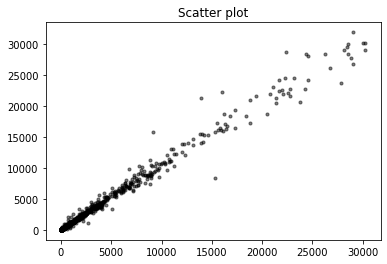

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


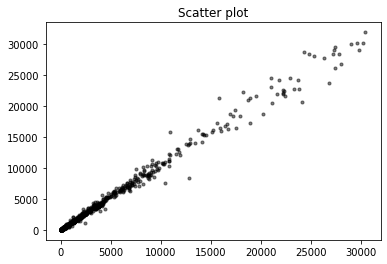

Linear Regression Metrics
Mean Absolute Error: 109.33808907739044
Mean Squared Error: 106210.0079553931
Root Mean Squared Error: 325.89876949045555
R-squared: 0.9922397601181691


In [50]:
x1 = df[['lag_sgna', 'sgna_mkt']]
y1 = df['sgna']
scatter_plot(x = x1['lag_sgna'], y = y1)
scatter_plot(x = x1['sgna_mkt'], y = y1)
x1.fillna(0,inplace=True)
print("Linear Regression Metrics")
rd=LinearReg(x1,y1)
pred=RegPredict(rd,x1,y1)

Distribution of residuals


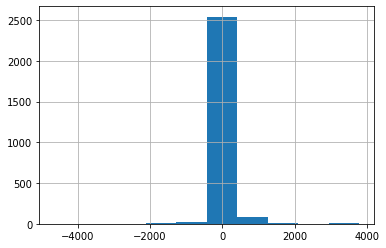

In [51]:
df['R1'] = df['sgna'] - pred
print("Distribution of residuals")
df['R1'].hist()

### Model 4: DV= gross_profit, IV= SGNA and SQ_SGNA; moderating variables: all created above; CONTROL= current assets, age, ppe, emp, operating expenses, liabilities, book value, r1

#### Defining Variables

In [52]:
DV = ['gross_profit']
IV = ['sgna', 'SQ_SGNA']
MV = ['sgna_litigation', 'sgna_no_of_cases', 'sgna_developed', 'sgna_multinational',
     'sgna_Australia', 'sgna_Belgium', 'sgna_Germany', 'sgna_India', 'sgna_Ireland', 'sgna_Norway', 
     'sgna_Singapore', 'sgna_Sweden', 'sgna_UK', 'sgna_USA', 'sgna_policy_reform_Australia',
     'sgna_policy_reform_Germany', 'sgna_policy_reform_India', 'sgna_policy_reform_Norway', 'sgna_policy_reform_Singapore',
     'sgna_policy_reform_Sweden', 'sgna_policy_reform_UK', 'sgna_policy_reform_USA', 'sgna_gdp per capita growth', 'sgna_life_expectancy',
     'sgna_mortality','sgna_population', 'sgna_Individuals_using _the_Internet', 'sgna_physicians', 'sgna_acquisitions']
CV = ['current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','R1']

In [53]:
np.mean(df['gross_profit'])

2592.69788957603

In [86]:
X = df[IV + CV + MV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Linear Regression

Linear Regression Results - with Imputation
Mean Absolute Error: 596.2928476373644
Mean Squared Error: 1034833.6525857233
Root Mean Squared Error: 1017.2677388896806
R-squared: 0.9687080666163975


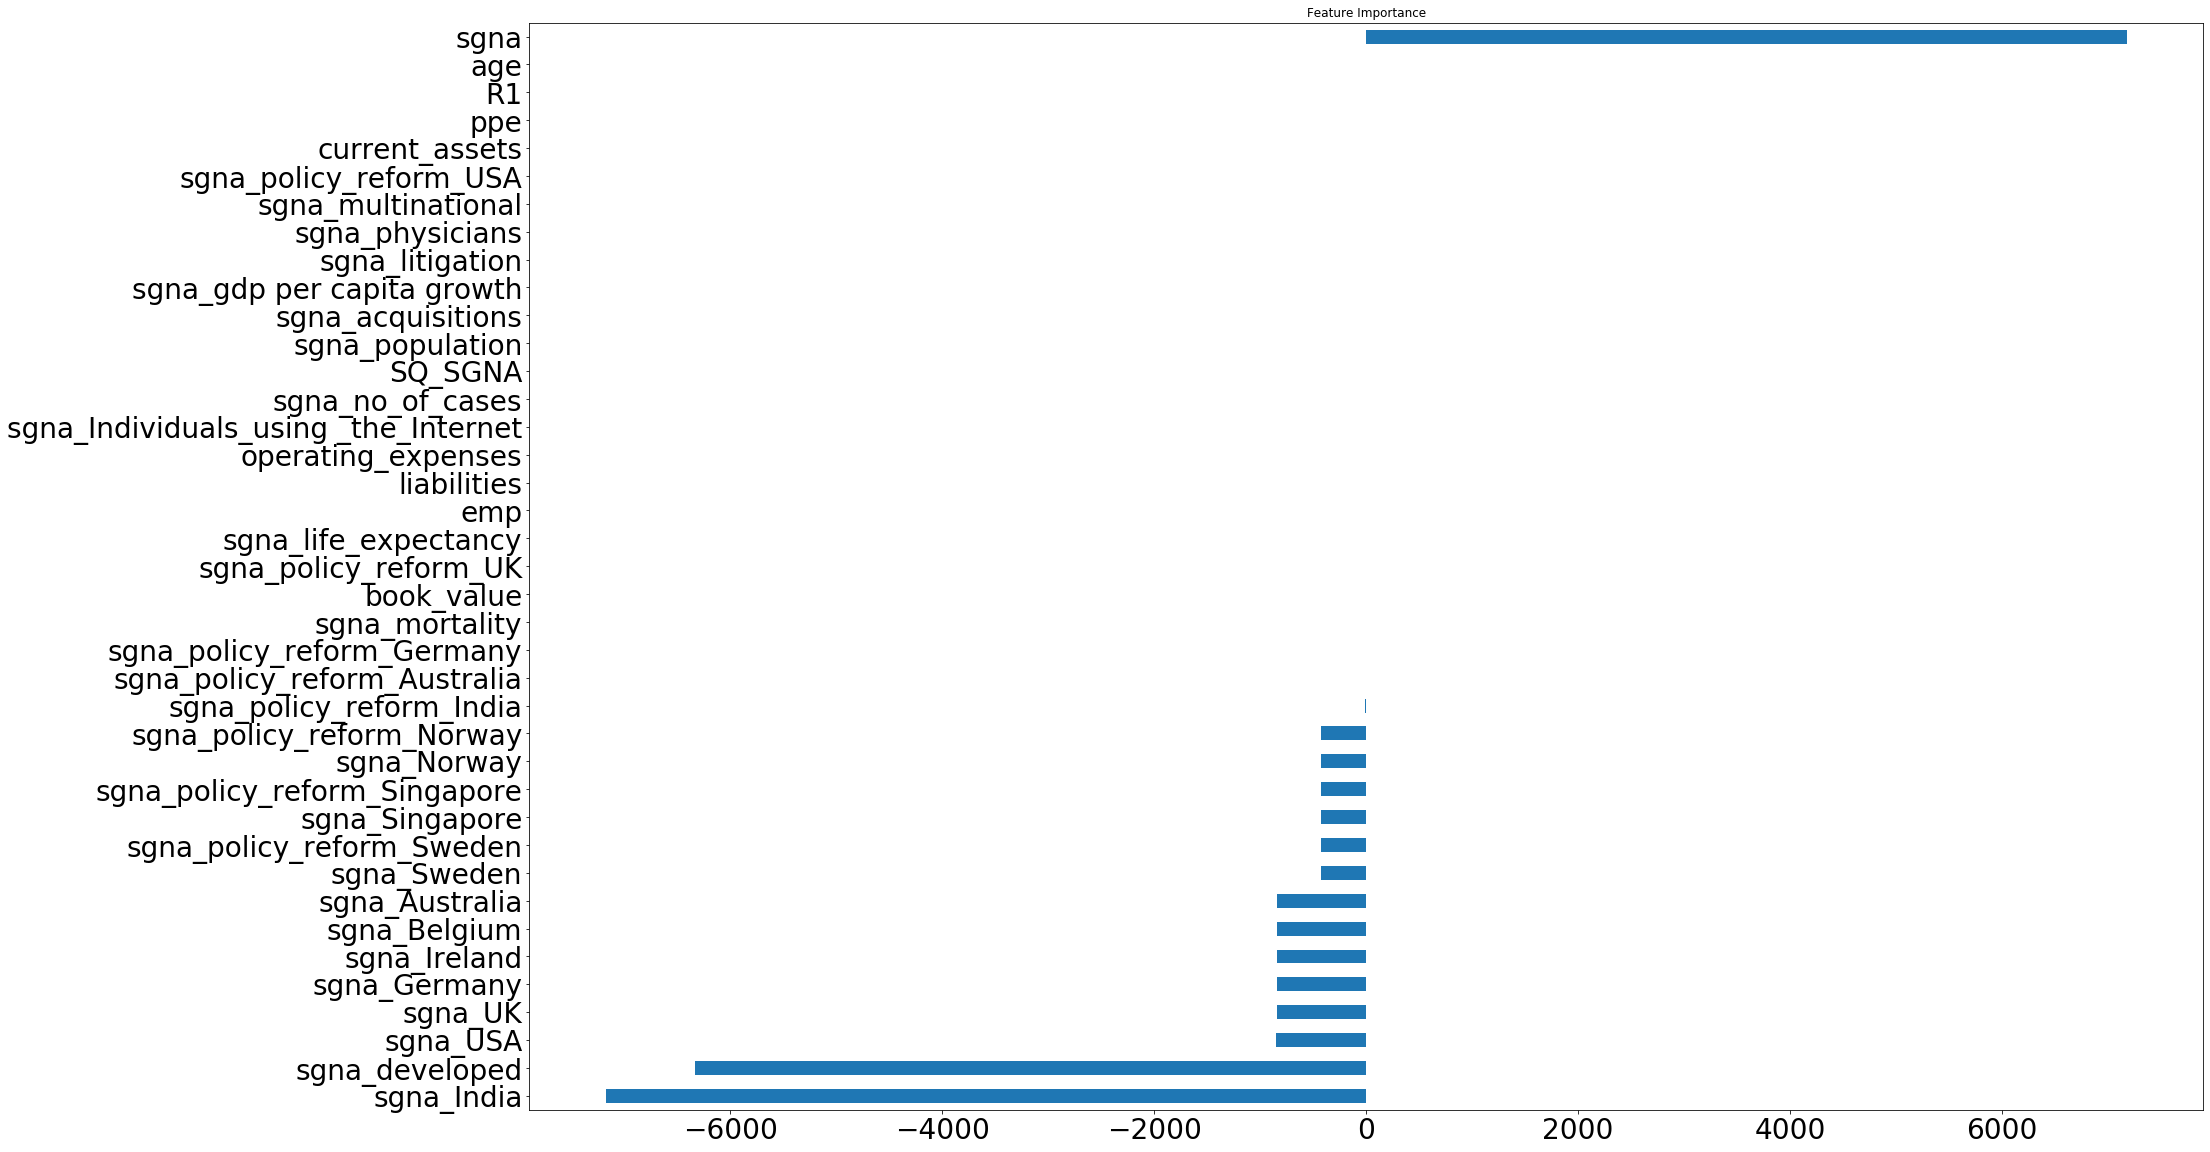

In [87]:
print("Linear Regression Results - with Imputation")
lr=LinearReg(X_train,y_train)
pred=RegPredict(lr,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(lr,index=feature_list)

### Lasso Regression

Lasso Regression Metrics - with Imputation
Mean Absolute Error: 595.9135118739512
Mean Squared Error: 1025265.7529477106
Root Mean Squared Error: 1012.5540740857797
R-squared: 0.9689973866219324


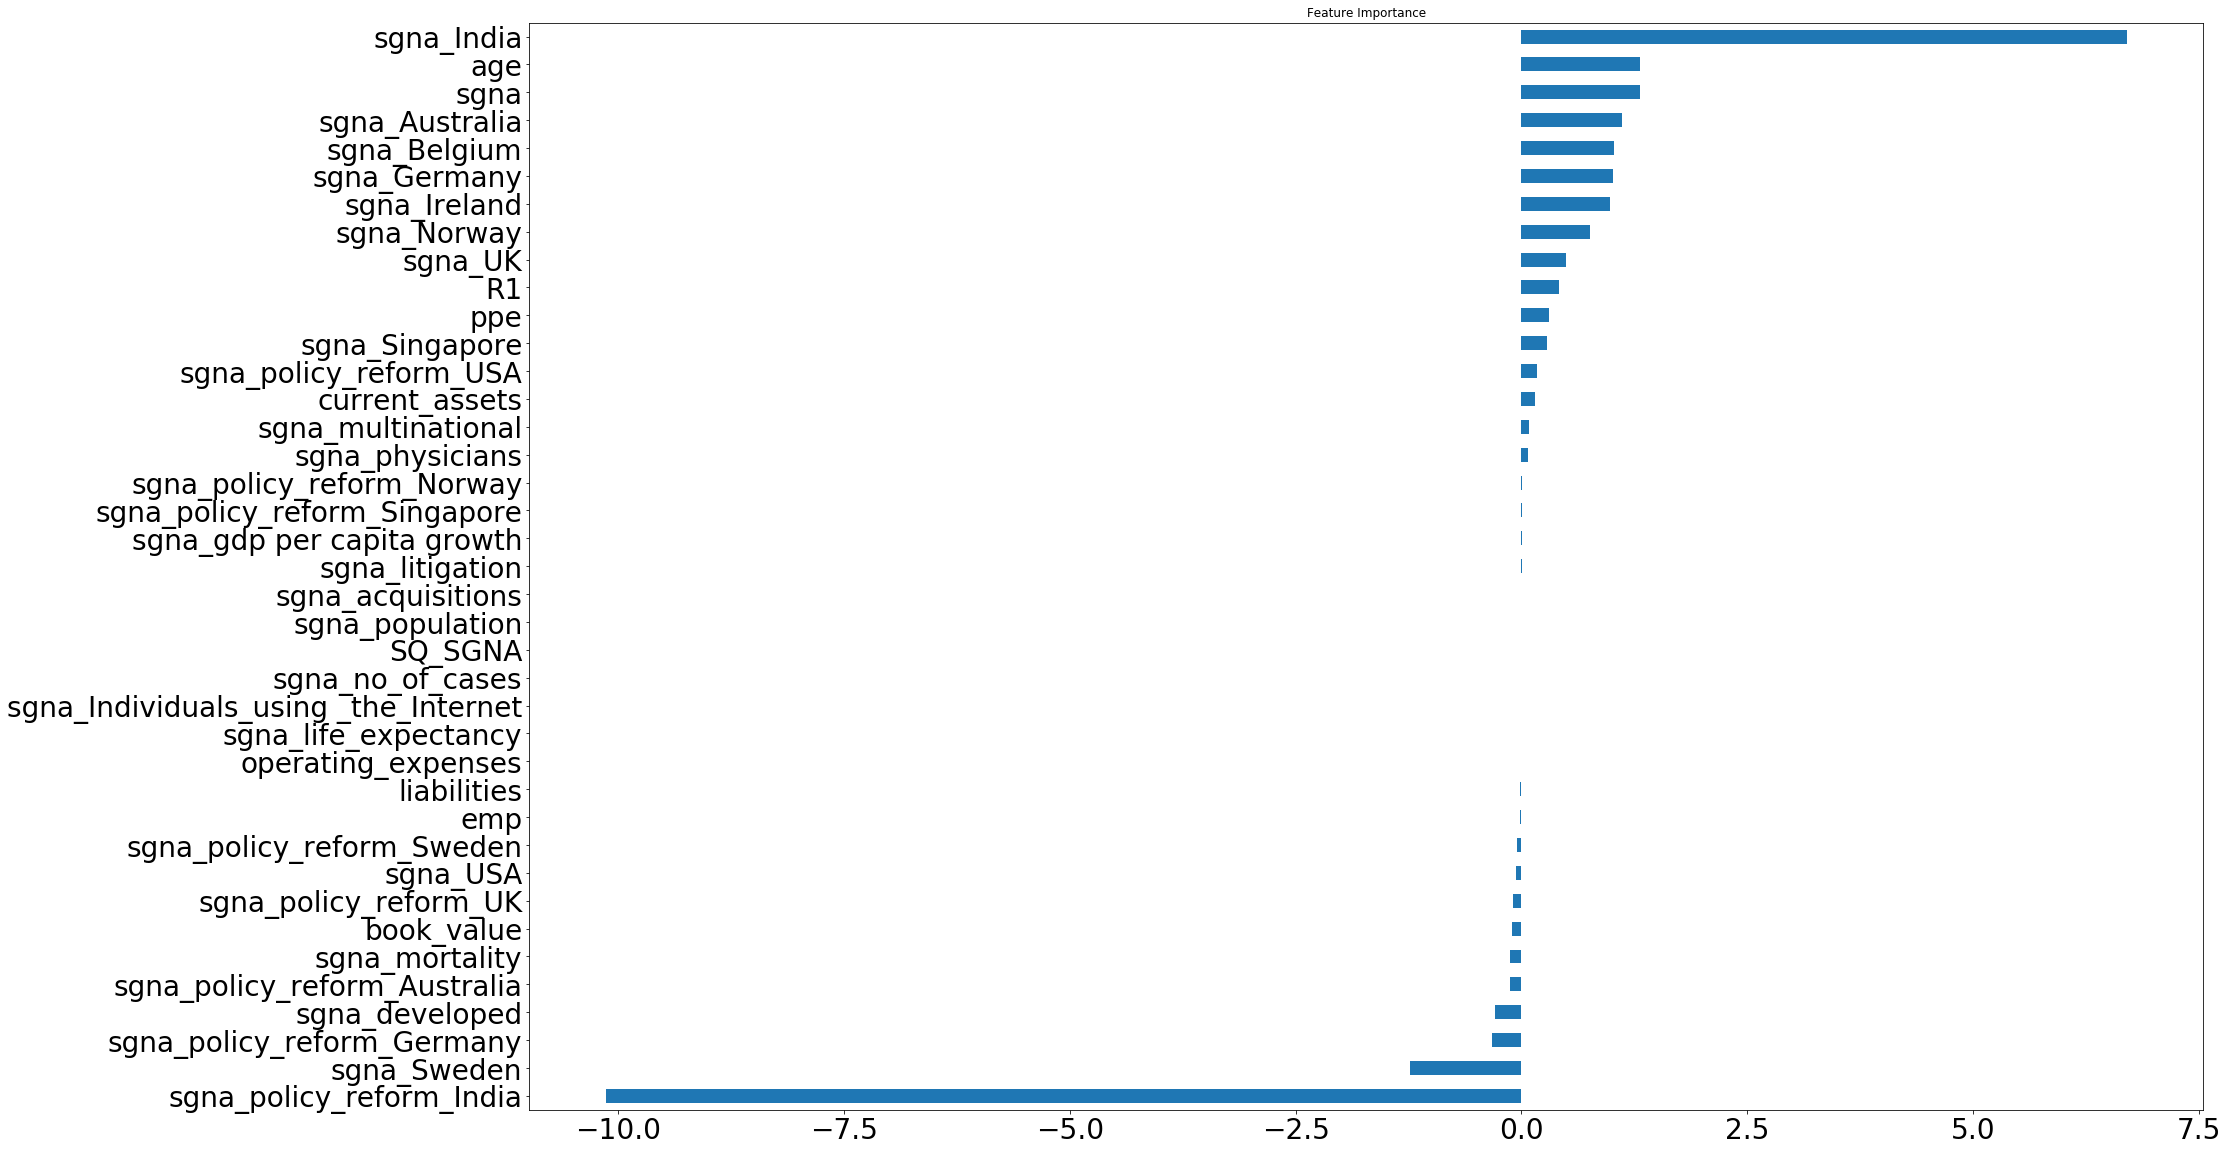

In [88]:
print("Lasso Regression Metrics - with Imputation")
las=LassoReg(X_train,y_train)
pred=RegPredict(las,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp_EN(las,index=feature_list)

### Ridge Regression

Ridge Regression Metrics -- With Imputation
Mean Absolute Error: 596.2936692164169
Mean Squared Error: 1034833.2529339195
Root Mean Squared Error: 1017.2675424557295
R-squared: 0.9687080787013134


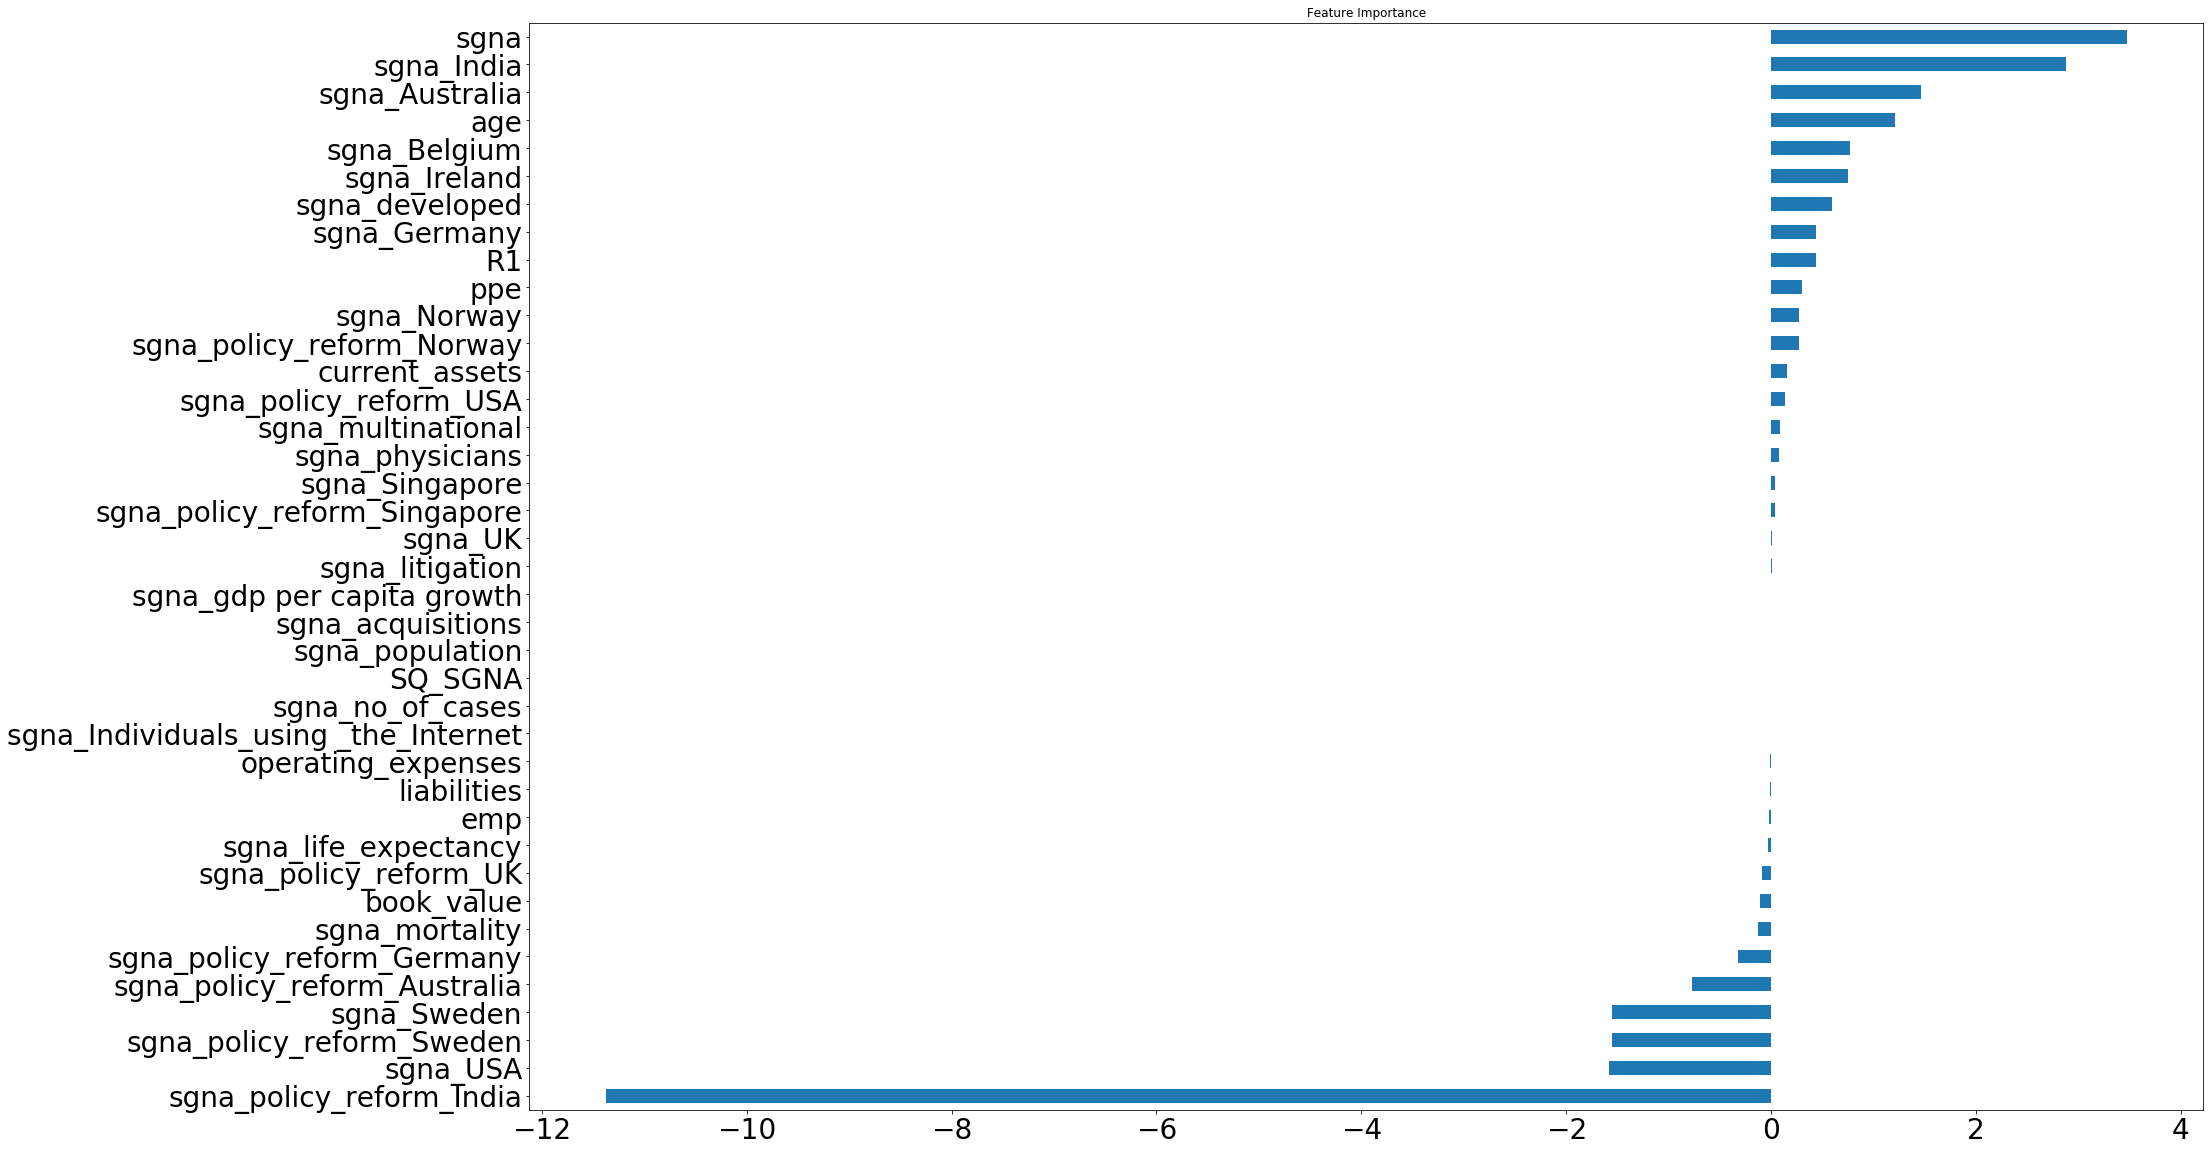

In [89]:
print("Ridge Regression Metrics -- With Imputation")
rd=RidgeReg(X_train,y_train)
pred=RegPredict(rd,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(rd,index=feature_list)

### ElasticNet Regression

ElasticNet Regression Results - with Imputation
Mean Absolute Error: 595.8982527405927
Mean Squared Error: 1025207.5359979093
Root Mean Squared Error: 1012.5253261019742
R-squared: 0.9689991470216937


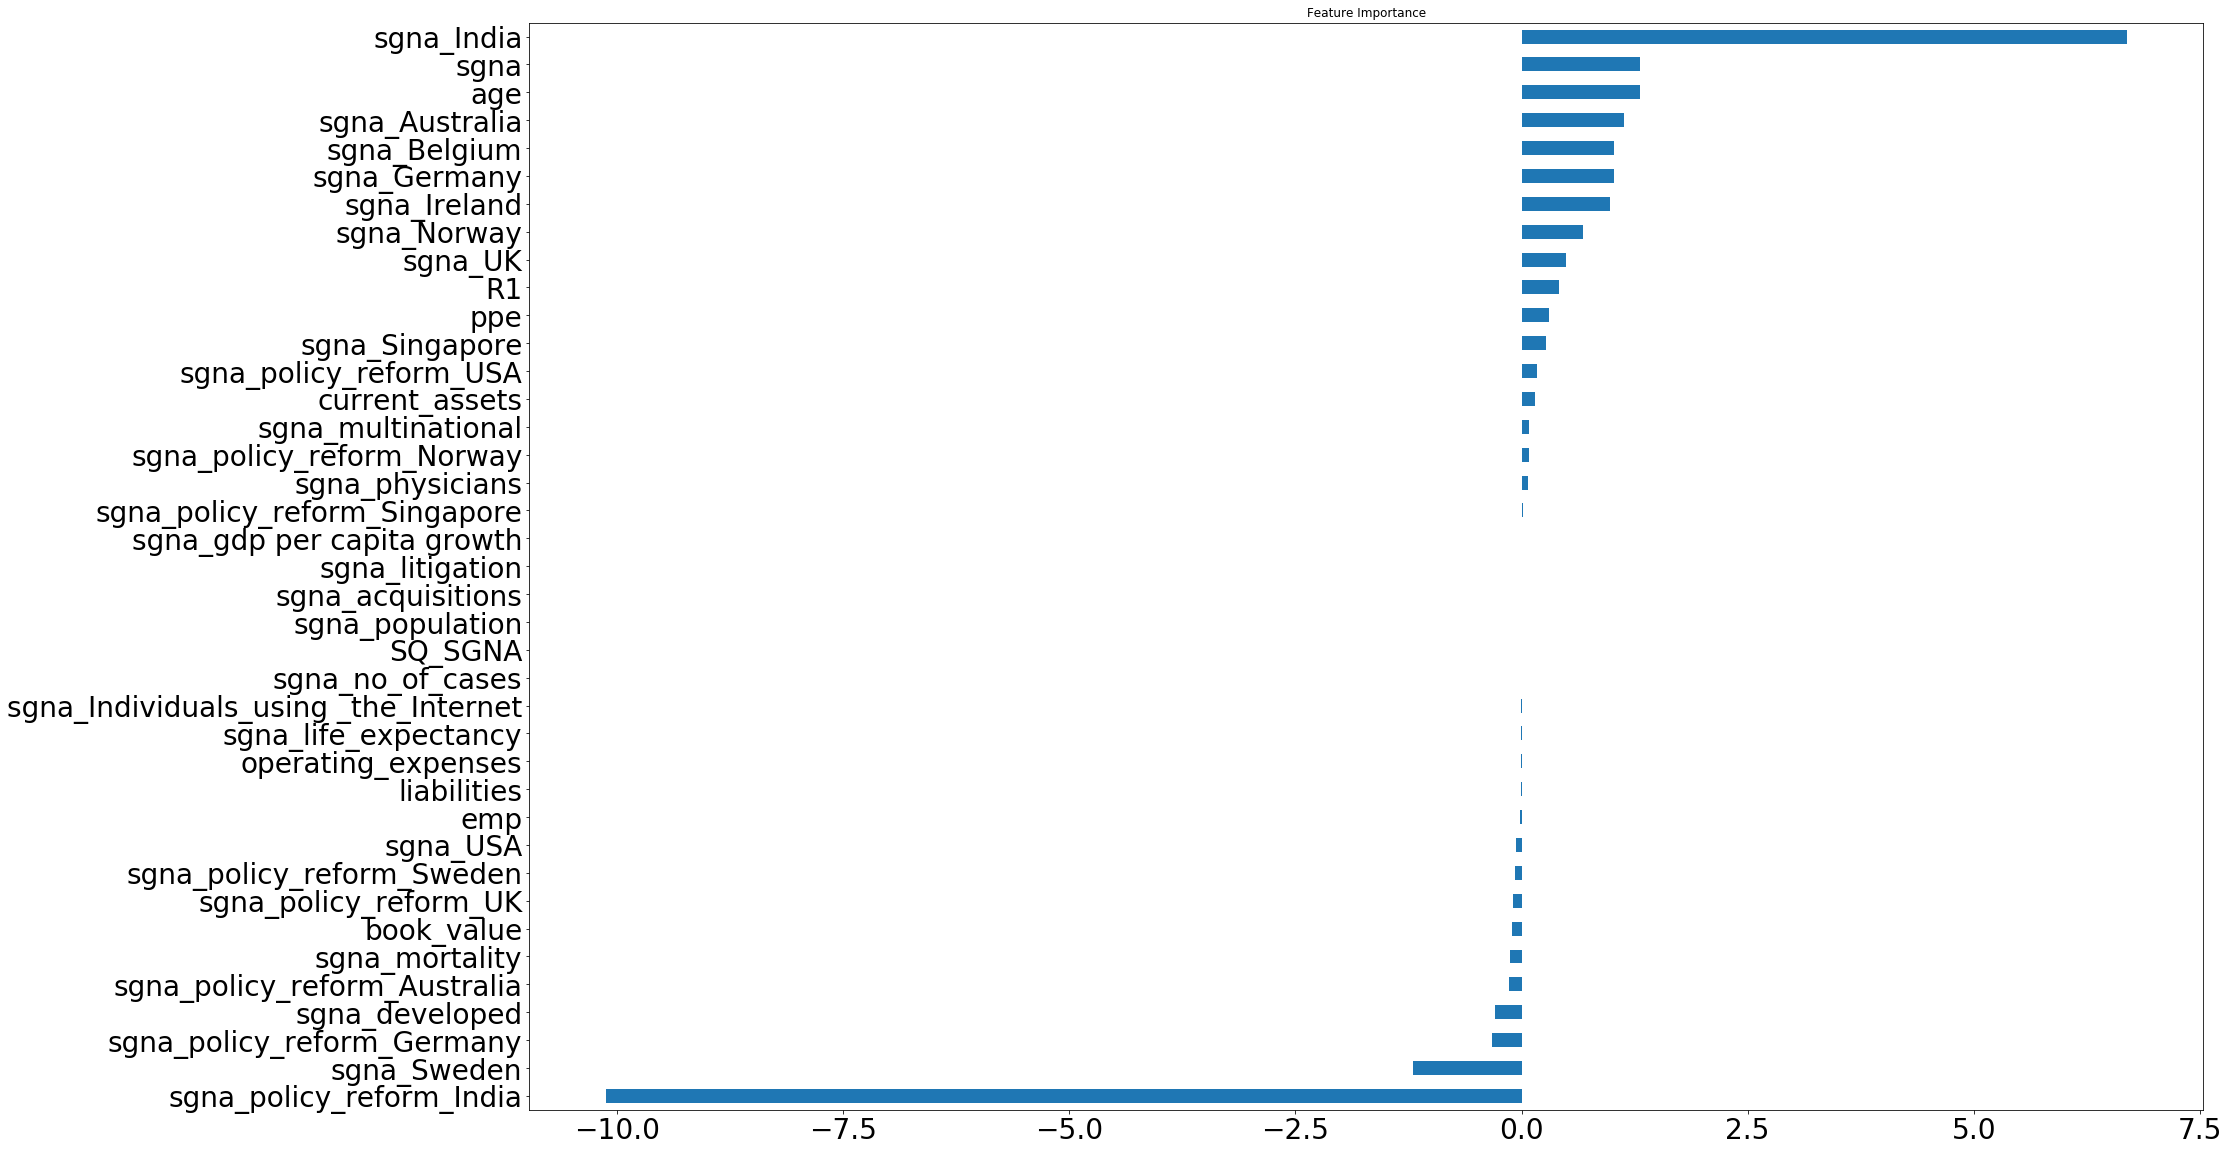

In [90]:
print("ElasticNet Regression Results - with Imputation")
en=ElasticNetReg(X_train,y_train)
pred=RegPredict(en,X_test,y_test)

#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp_EN(en,index=feature_list)

### Support Vector Regression

In [91]:
print("Support Vector with RBF Kernel Regression Results - With Imputation")
svr=SVR_RBF(X_train,y_train)
pred=RegPredict(svr,X_test,y_test)

Support Vector with RBF Kernel Regression Results - With Imputation
Mean Absolute Error: 2288.514538196069
Mean Squared Error: 37472292.029692
Root Mean Squared Error: 6121.461592601231
R-squared: -0.13311010227982978


In [92]:
print("Linear Support Vector Regression Results - With Imputation")
svr=SVR_Linear(X_train,y_train)
pred=RegPredict(svr,X_test,y_test)

Linear Support Vector Regression Results - With Imputation
Mean Absolute Error: 9524755.980683511
Mean Squared Error: 654704890958655.9
Root Mean Squared Error: 25587201.702387385
R-squared: -19797366.221878074


### XGBoost Regression

XGBoost Regression Results - With Imputation
Mean Absolute Error: 209.59354742258094
Mean Squared Error: 308441.2453737845
Root Mean Squared Error: 555.3748692313909
R-squared: 0.9906731648329418


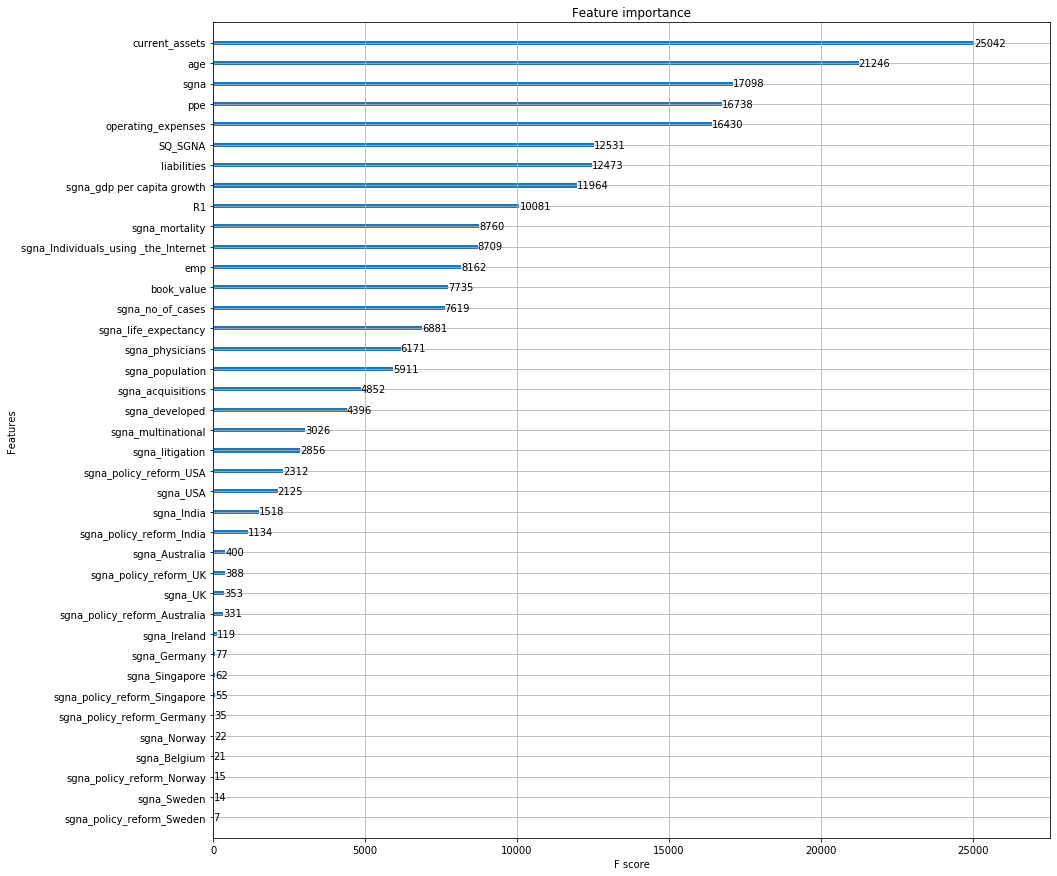

In [93]:
print("XGBoost Regression Results - With Imputation")
xg=XGBoostReg(X_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,X_test,y_test)

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

### Bayesian Ridge Regression

In [69]:
print("Bayesian Ridge Regression Results--With Imputation")
br=BayesianRidgeReg(X_train,y_train)
pred=RegPredict(br,X_test,y_test)

Bayesian Ridge Regression Results--With Imputation
Mean Absolute Error: 619.4605422692428
Mean Squared Error: 1036971.7488446054
Root Mean Squared Error: 1018.3180980639622
R-squared: 0.9686434135530443


### AdaBoosting

In [70]:
print("AdaBoosting Results--With Imputation")
adb=AdaBoost(X_train,y_train,n_estimators=100,learning_rate=1)
pred=RegPredict(adb,X_test,y_test)

AdaBoosting Results--With Imputation
Mean Absolute Error: 1247.8150926649955
Mean Squared Error: 2115942.0326022897
Root Mean Squared Error: 1454.62779864895
R-squared: 0.9360168497010969


### Decision Tree Regression

In [71]:
print("Decision Tree Results --WithImputation")
dt=DecisionTreeReg(X_train,y_train,max_depth=100)
pred=RegPredict(dt,X_test,y_test)

print("---------------------------------------")
dt=DecisionTreeReg(X_train,y_train,max_depth=200)
pred=RegPredict(dt,X_test,y_test)

Decision Tree Results --WithImputation
Mean Absolute Error: 360.45588470648454
Mean Squared Error: 1829208.3303817858
Root Mean Squared Error: 1352.482284683162
R-squared: 0.9446872788916227
---------------------------------------
Mean Absolute Error: 339.6550375693934
Mean Squared Error: 1744865.4735110542
Root Mean Squared Error: 1320.9335613538835
R-squared: 0.947237689821908


### Orthogonal Matching Pursuit

In [72]:
print("Orthogonal Matching Pursuit Results--With Imputation")
omp=OrthogonalMatchReg(X_train,y_train)
pred=RegPredict(omp,X_test,y_test)

Orthogonal Matching Pursuit Results--With Imputation
Mean Absolute Error: 631.7885441241406
Mean Squared Error: 1090884.5609172867
Root Mean Squared Error: 1044.4541928286212
R-squared: 0.9670131649428588


### Robust Linear Model Estimation using RANSAC

In [73]:
print("RANSAC Regression Results--With Imputation")
ran=RansacReg(X_train,y_train)
pred=RegPredict(ran,X_test,y_test)

RANSAC Regression Results--With Imputation
Mean Absolute Error: 2490.1623760851567
Mean Squared Error: 43586822.73733615
Root Mean Squared Error: 6602.031712839325
R-squared: -0.31800502437431843


### RandomForest Regression

In [74]:
print("RandomForest Regression Results--With Imputation")
rf=RandomForestReg(X_train,y_train,n_estimators = 1000, random_state = 42)
pred=RegPredict(rf,X_test,y_test)
print("-----------------------------------------")
rf=RandomForestReg(X_train,y_train,n_estimators = 500, random_state = 42)
pred=RegPredict(rf,X_test,y_test)

RandomForest Regression Results--With Imputation
Mean Absolute Error: 210.6913522141532
Mean Squared Error: 341851.17215992097
Root Mean Squared Error: 584.6804017238144
R-squared: 0.9896628950173724
-----------------------------------------
Mean Absolute Error: 211.2606594450129
Mean Squared Error: 348044.87485449127
Root Mean Squared Error: 589.9532819253498
R-squared: 0.9894756060442779


### Gradient Boosting Regression

In [75]:
print("Gradient Boosting Regression Results--With Imputation")
gb=GradientBoostReg(X_train,y_train,n_estimators=1000,max_depth=30,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test,y_test)
print("------------------------------------------")
gb=GradientBoostReg(X_train,y_train,n_estimators=500,max_depth=50,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test,y_test)

Gradient Boosting Regression Results--With Imputation
Mean Absolute Error: 330.71258487322734
Mean Squared Error: 1646646.9555024412
Root Mean Squared Error: 1283.2174233162675
R-squared: 0.9502076814866379
------------------------------------------
Mean Absolute Error: 352.6136221366519
Mean Squared Error: 1704927.532982585
Root Mean Squared Error: 1305.728736370072
R-squared: 0.9484453577126578


### Stepwise Regression

In [76]:
result = stepwise_selection(X_train, y_train)
print('Resulting features from Stepwise Selection with Imputation:')
print(result) 

Add  sgna_life_expectancy           with p-value 0.0
Add  ppe                            with p-value 9.70229e-95
Add  sgna_policy_reform_USA         with p-value 2.04438e-66
Add  current_assets                 with p-value 4.00903e-23
Add  sgna_physicians                with p-value 1.39739e-26
Drop sgna_life_expectancy           with p-value 0.547954
Add  emp                            with p-value 1.69943e-18
Add  sgna_multinational             with p-value 3.85714e-08
Add  sgna_mortality                 with p-value 1.75744e-05
Add  sgna_India                     with p-value 1.35258e-05
Add  sgna_policy_reform_India       with p-value 3.90026e-08
Add  sgna_developed                 with p-value 4.8677e-10
Add  sgna                           with p-value 7.4631e-20
Add  R1                             with p-value 1.18483e-05
Add  liabilities                    with p-value 5.09087e-06
Add  sgna_UK                        with p-value 0.000157323
Add  SQ_SGNA                        w

In [77]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=30)
rfecv = RFECV(estimator=reg, step=1, cv=5)
rfecv.fit(X,y)

print('Optimal number of features: {}'.format(rfecv.n_features_))
rfecv.support_ 

#print(X.columns)
rfecv.ranking_

Optimal number of features: 22


array([ 2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  9, 11, 10,
        6, 17, 16,  8, 12,  5,  1,  1, 13,  7, 14, 18, 15,  4,  1,  1,  1,
        1,  1,  1,  1,  3])

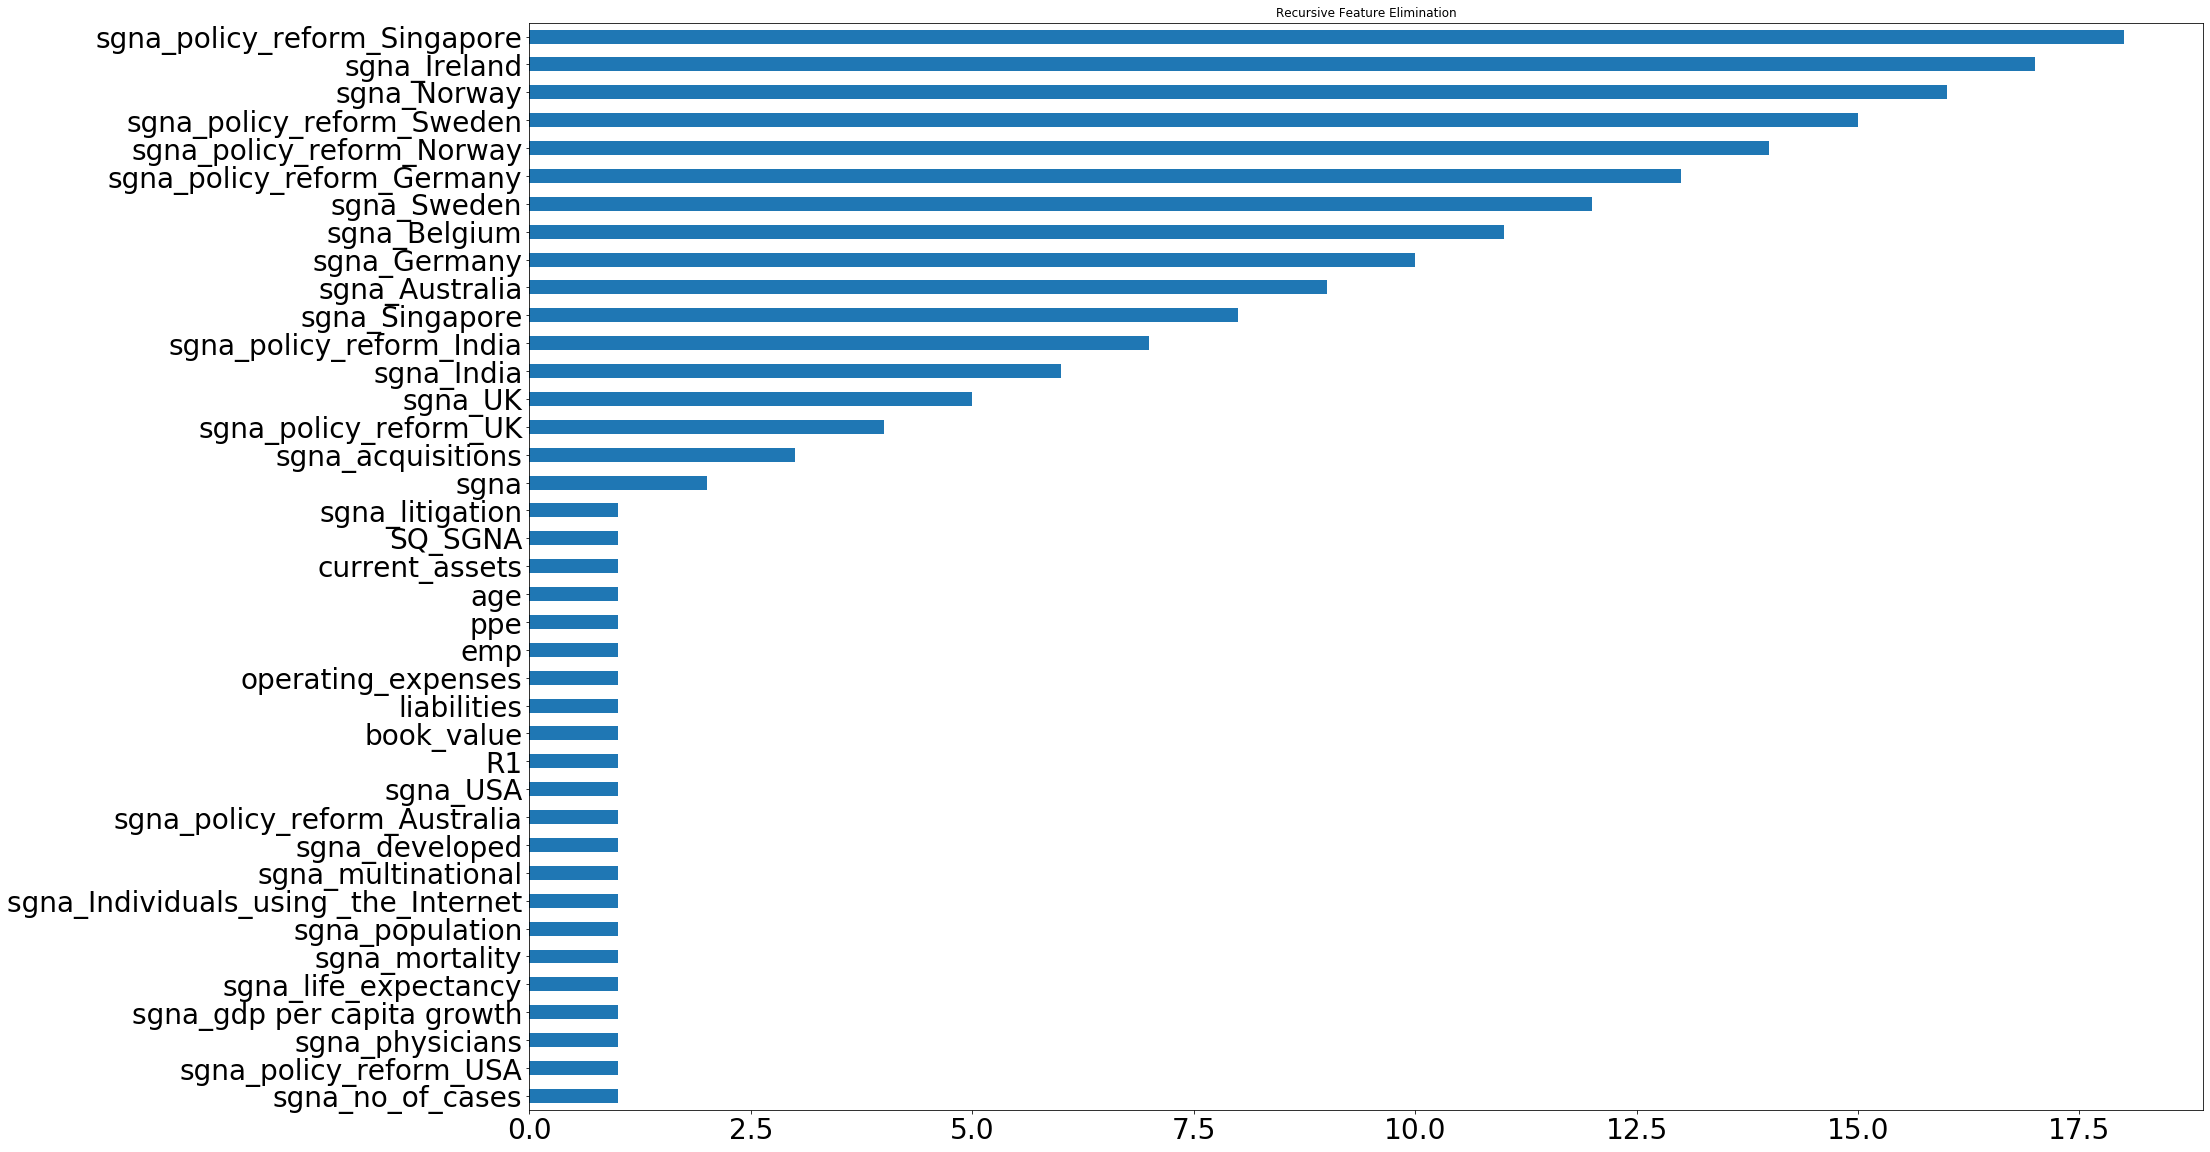

In [78]:
feature_list = list(X.columns)

feature_imp = pd.Series(rfecv.ranking_, index=feature_list).sort_values(ascending=True)
feature_imp.plot(kind='barh', title='Recursive Feature Elimination',figsize=(30, 20), fontsize=28)
#plt.figure(figsize=(100, 50))
plt.show()

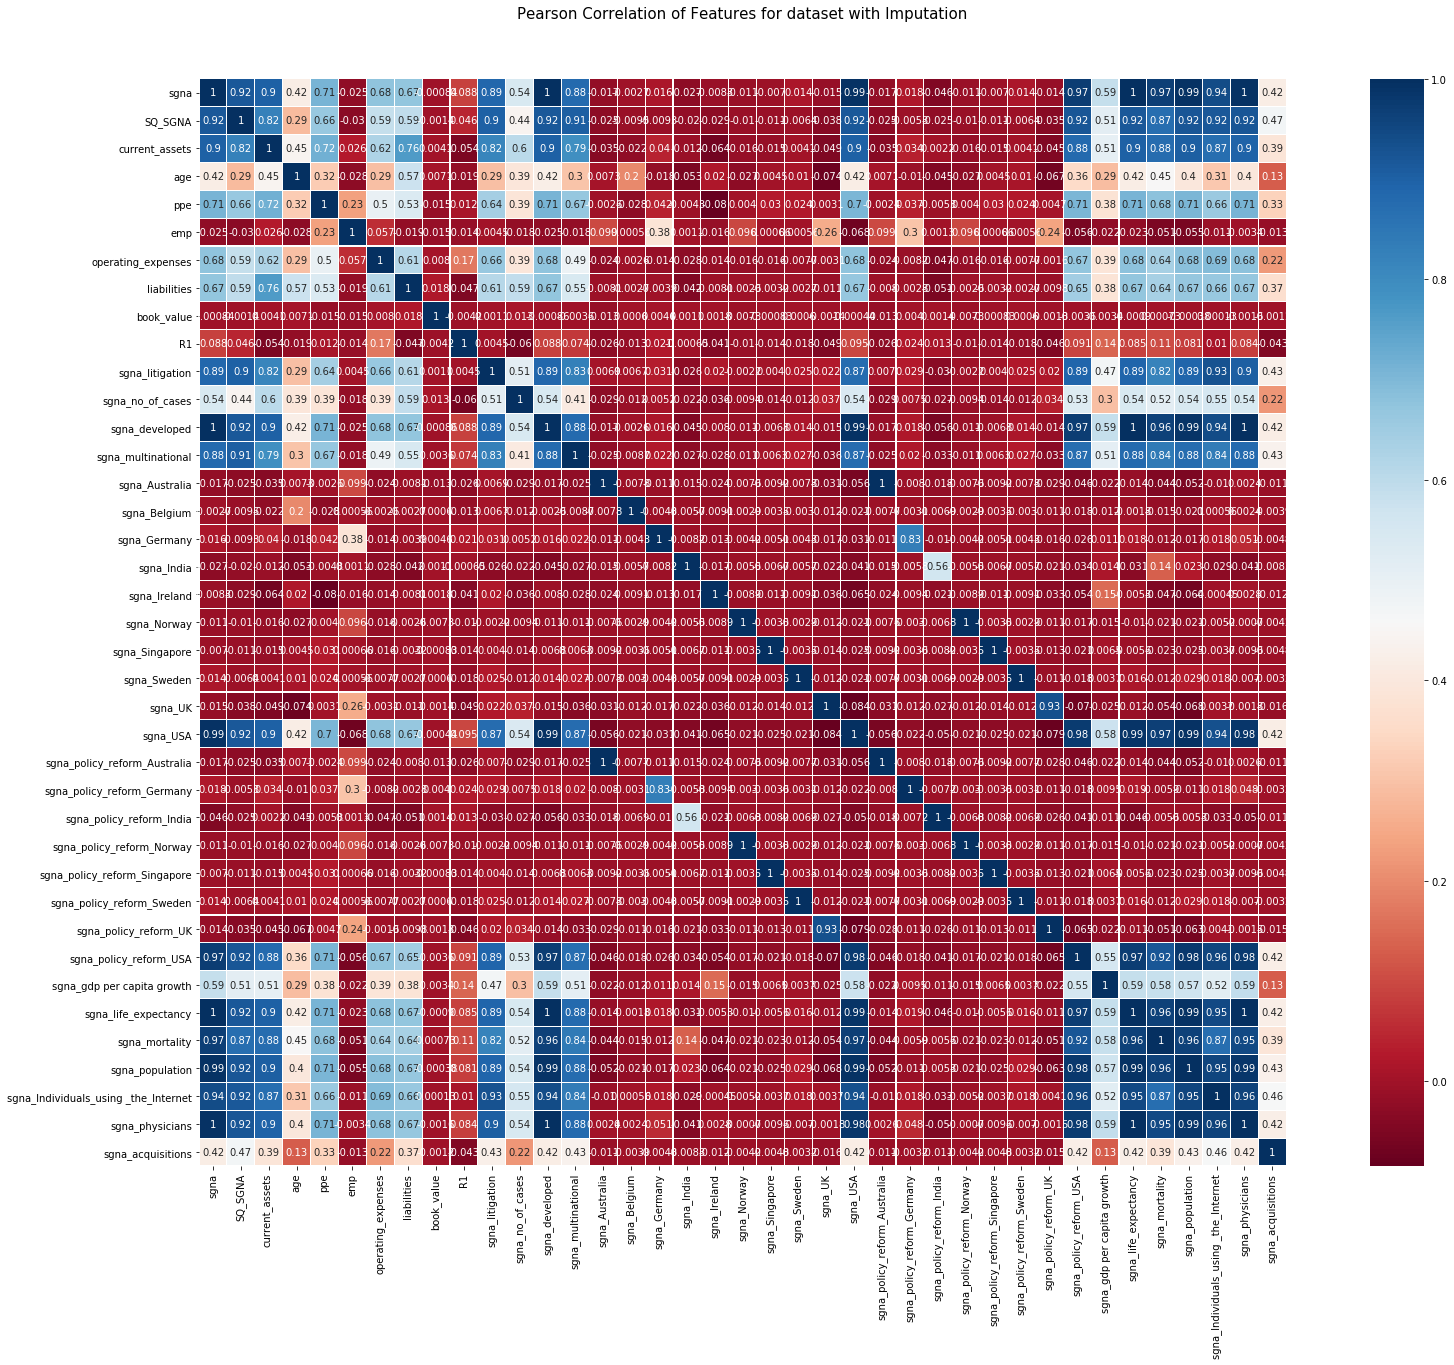

In [80]:
colormap = plt.cm.RdBu
plt.figure(figsize=(30,20))
plt.title('Pearson Correlation of Features for dataset with Imputation', y=1.05, size=15)
sns.heatmap(X.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the
# correlation matrix.

### PCA

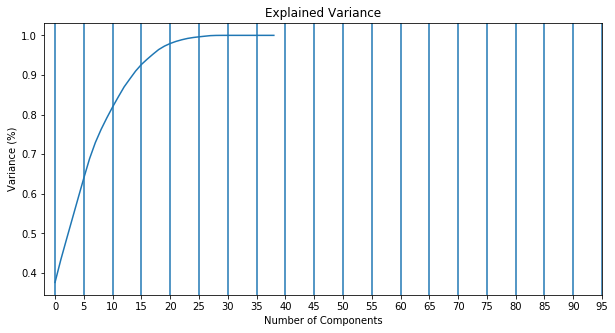

In [95]:
from sklearn.preprocessing import StandardScaler
#features = data.loc[:, (data.columns != 'Machine_State') & (data.columns != 'target')].columns

# Separating out the features
x = X.values
# Separating out the target

x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
import numpy as np
#Fitting the PCA algorithm with our Data
pca = PCA().fit(x)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 100, 5))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
xcoords = np.arange(0, 100, 5)
for xc in xcoords:
    plt.axvline(x=xc)


plt.show()

In [96]:
pca = PCA(n_components=35)
dataset = pca.fit_transform(x)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.33, random_state = 42)

print("Linear Regression Results - with Imputation")
lr=LinearReg(x_train,y_train)
pred=RegPredict(lr,x_test,y_test)

Linear Regression Results - with Imputation
Mean Absolute Error: 625.9641485668656
Mean Squared Error: 1339520.40401065
Root Mean Squared Error: 1157.3765178241047
R-squared: 0.9741868745871373


In [84]:
print("Bayesian Ridge Regression Results--With Imputation")
br=BayesianRidgeReg(x_train,y_train)
pred=RegPredict(br,x_test,y_test)

Bayesian Ridge Regression Results--With Imputation
Mean Absolute Error: 632.7660834656967
Mean Squared Error: 1363997.7748093277
Root Mean Squared Error: 1167.9031530094128
R-squared: 0.9737151852867642


In [97]:
print("Bayesian Ridge Regression Results--With Imputation")
xg=XGBoostReg(x_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,x_test,y_test)

Bayesian Ridge Regression Results--With Imputation
Mean Absolute Error: 461.38570849013934
Mean Squared Error: 2259337.04759726
Root Mean Squared Error: 1503.10912697557
R-squared: 0.956461618363604
